In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from dataloader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dataloader = DataLoader(utils.train_dir, batch_size=24, transfer=False)

In [5]:
USE_GPU = False
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [36]:
def train(model, optimizer, epochs=1):
    """
    Train a model on image data using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    
    print_every = 4
    val_every = 20
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    
    for e in range(epochs):
        for t, (fxy, x, y) in enumerate(dataloader):
            model.train()  # put model to training mode
            
            x = torch.from_numpy(x)
            y = torch.from_numpy(y)
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
            if t != 0 and t % val_every == 0:
                print('Checking validation accuracy:')
                check_accuracy(model)
                print()
            if t > 10:
                break


def check_accuracy(model):
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    
    loader = DataLoader('/scratch/users/gmachi/codex/data/val/', batch_size=2, transfer=False)
    
    with torch.no_grad():
        for i, (fxy, x, y) in enumerate(loader):

            x = torch.from_numpy(x)
            y = torch.from_numpy(y)
            
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    def forward(self, x):
        print(x.shape)
        return x




In [25]:
# same structure as vgg19 model print(torchvision.models.vgg19(pretrained=False, progress = True))
model = nn.Sequential(
    
    nn.Conv2d(75, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
    nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
    nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
    nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
    
    Flatten(),
    nn.Linear(in_features= 4608, out_features=4096, bias=True),
    nn.ReLU(inplace = True),
    nn.Dropout(p=0.5),
    
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(inplace = True),
    nn.Dropout(p=0.5),
    
    nn.Linear(in_features=4096, out_features=2, bias=True),
    
)


# TO DEBUG MODEL:::
# add PrintLayer(), or use summary from torchsummary module:
# summary(your_model, input_size=(channels, H, W))
# https://towardsdatascience.com/model-summary-in-pytorch-b5a1e4b64d25  

In [26]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
train(model, optimizer)

Iteration 0, loss = 0.7074
Iteration 4, loss = 0.6798
Iteration 8, loss = 0.6516


In [28]:
torch.save(model, '/Users/sehjkashyap/Documents/stanford/courses/cs231n-images/codex/models/vgg19.pth')



/anaconda3/envs/cs231n/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Saliency Mapping

## *Helper Functions*

In [6]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

## *Load pre-trained model*

In [12]:
# We need to define the Flatten class again before model is loaded... weird pytorch thing
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

model_pt = torch.load(utils.model_dir + 'conv2d_v2_epoch3.pt')
model_pt.eval()

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
#for param in model.parameters():
    #param.requires_grad = False

# you may see warning regarding initialization deprecated, that's fine, please continue to next steps

Sequential(
  (0): Conv2d(75, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, paddin

## *Make Saliency maps*

In [14]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, C, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    
    s = model.forward(X)
    sg = s.gather(1, y.view(-1, 1)).squeeze()
    loss = torch.sum(sg)
    loss.backward()
    values, _ = torch.max(X.grad, 1)
    saliency = torch.abs(values)

    return saliency

In [20]:
def show_saliency_maps(X, y, model):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.from_numpy(X)
    y_tensor = torch.from_numpy(y)
            
    X_tensor = X_tensor.to(device=device, dtype=dtype)  # move to device, e.g. GPU
    y_tensor = y_tensor.to(device=device, dtype=torch.long)
    
    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    
    for i in range(N):
        plt.subplot(2, N, i + 1)
        #plt.imshow(X[i])
        plt.axis('off')
        #plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()


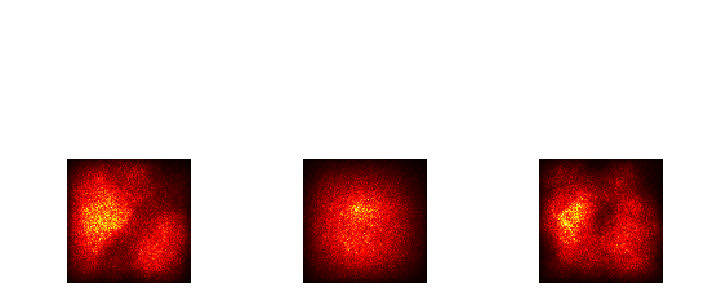

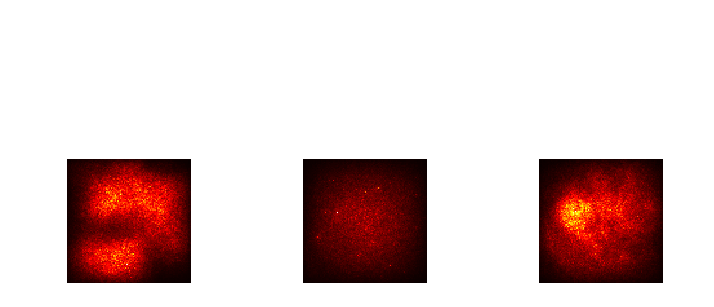

In [21]:
saliency_loader = DataLoader(utils.train_dir, batch_size=3, transfer=False)
for i, (fxy, X, y) in enumerate(saliency_loader):
    show_saliency_maps(X, y, model_pt)
    if i > 0:
        break

# Per Channel

In [24]:
def compute_saliency_maps_per_channel(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, C, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    # Make input tensor require gradient
    X.requires_grad_()
    
    saliency = None
    
    s = model.forward(X)
    sg = s.gather(1, y.view(-1, 1)).squeeze()
    loss = torch.sum(sg)
    loss.backward()
    saliency = torch.abs(X.grad)

    return saliency

In [103]:
def show_saliency_maps_per_channel(X, y, model):
    
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.from_numpy(X)
    y_tensor = torch.from_numpy(y)
            
    X_tensor = X_tensor.to(device=device, dtype=dtype)  # move to device, e.g. GPU
    y_tensor = y_tensor.to(device=device, dtype=torch.long)
    
    # Compute saliency maps for images in X
    saliency = compute_saliency_maps_per_channel(X_tensor, y_tensor, model)
    saliency = saliency.numpy()
    
    N = saliency.shape[0]
    C = saliency.shape[1]
    fig, ax = plt.subplots(figsize=(10,25))
    activation_means = np.zeros((C,))
    for i in range(N):
        for c in range(C):
            pixel_activations = saliency[i, c, :, :]
            pixel_activations = pixel_activations.reshape(-1)
            activation_means[c] += np.sum(pixel_activations)
#             sns.distplot(pixel_activations, hist = False, hist_kws={'log':True})
#         ax.set_xscale('log')
    activation_means /= N
    sns.barplot(activation_means, list(range(C)), order=np.argsort(-activation_means), 
                orient='h', palette="Blues_d")
    ax.set_xscale('log')
    
    def change_width(ax, new_value):
        for patch in ax.patches:
            current_width = patch.get_height()
            diff = current_width - new_value

            # we change the bar width
            patch.set_height(new_value)

            # we recenter the bar
            patch.set_y(patch.get_y() + diff * .5)
    
    change_width(ax, 0.75)
    sns.despine(left=True, bottom=True)
    plt.show()
    

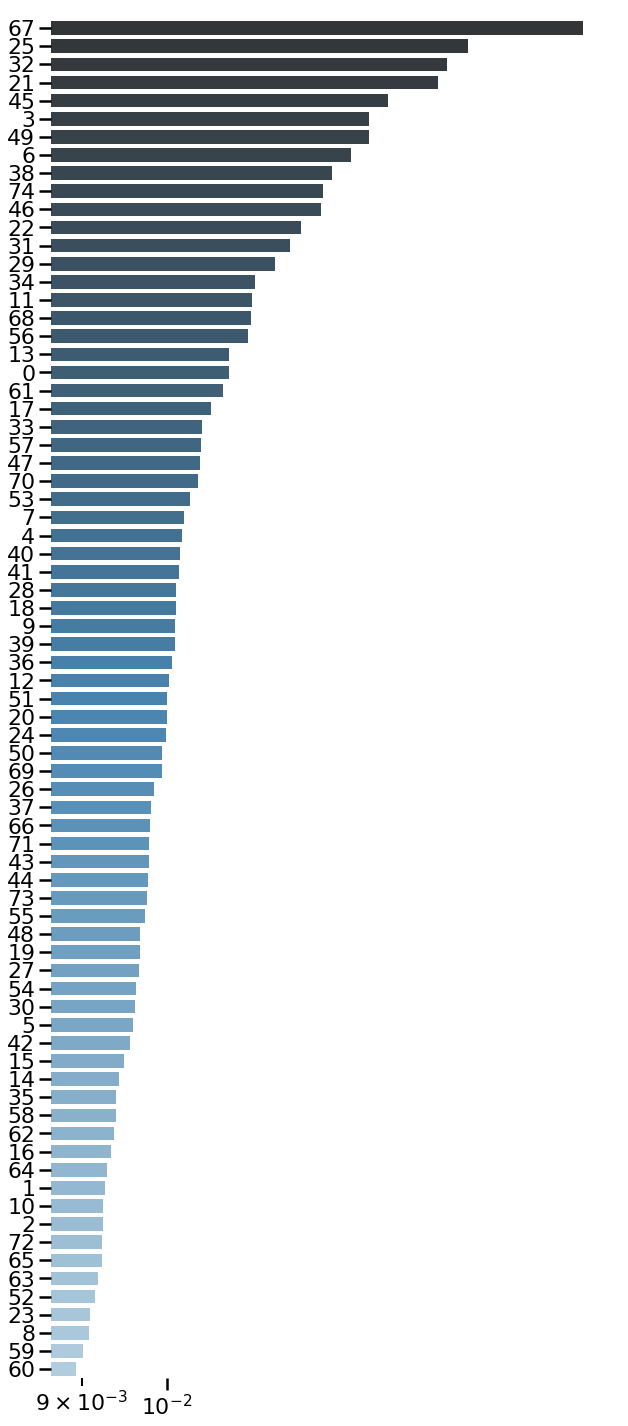

In [104]:
saliency_loader = DataLoader(utils.train_dir, batch_size=5, transfer=False)
for i, (fxy, X, y) in enumerate(saliency_loader):
    if i > 0:
        break
    show_saliency_maps_per_channel(X, y, model_pt)


# FCS Mapping

In [138]:
import sklearn
import pandas as pd
from sklearn.cluster import DBSCAN

In [ ]:
sklearn.cluster.DBSCAN(eps=0.5, 
                       min_samples=5, 
                       metric=’euclidean’, 
                       metric_params=None, 
                       algorithm=’auto’, 
                       leaf_size=30, 
                       p=None, 
                       n_jobs=None)

In [115]:
fcs_save_path = "/Users/sehjkashyap/Documents/stanford/courses/cs231n-images/codex/reg036_Compensated.csv_real.tsv"
df = pd.read_csv(fcs_save_path, sep="\t")   # read dummy .tsv file into memory
pos = df.values 

In [147]:
pos_channels = np.delete(pos,[0,1,2,3,4,5],1)

In [156]:
clustering = DBSCAN(eps=500, min_samples=2).fit(pos_channels)
# on reg_036 eps = 500, min_samples = 2 produced 36 classes

In [161]:
labels = clustering.labels_

In [163]:
xy = pos[:, (2,3)]

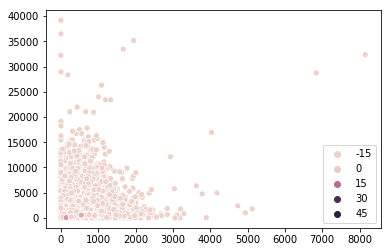

In [167]:
sns.scatterplot(xy[:, 0], xy[:, 1], hue = labels)

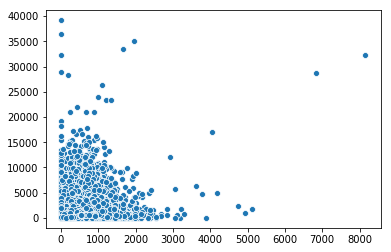

In [168]:
sns.scatterplot(pos[:, 2], pos[:, 3])

In [170]:
fcs_save_path = "/Users/sehjkashyap/Documents/stanford/courses/cs231n-images/codex/reg005_Compensated.csv_real.tsv"
df = pd.read_csv(fcs_save_path, sep="\t")   # read dummy .tsv file into memory
pos05 = df.values 

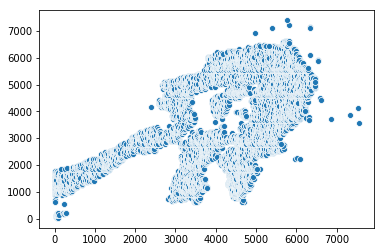

In [171]:
sns.scatterplot(pos05[:, 2], pos05[:, 3])

In [195]:
pos05_channels = np.delete(pos05, [0,1,4,5], 1)

In [196]:
# standardize data
scaler = sklearn.preprocessing.StandardScaler()
pos05_channels_norm = scaler.fit_transform(pos05_channels)

In [197]:
type(pos05_channels_norm)

numpy.ndarray

In [198]:
clustering_2 = DBSCAN(eps=5, min_samples=2).fit(pos05_channels_norm)
print(len(set(clustering_2.labels_)))
# for reg 05 eps = 5, min_samples = 2
# ideal is one major group and rest of about 10-100

39


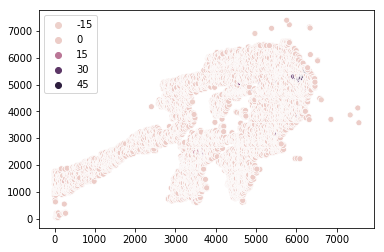

In [226]:
labels05 = clustering_2.labels_
xy05 = pos05[:, (2,3)]
sns.scatterplot(xy05[:, 0], xy05[:, 1], hue = labels05)

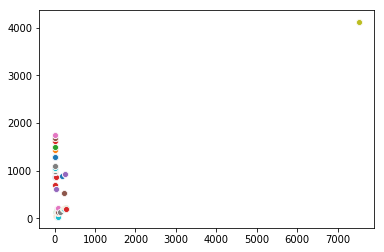

In [239]:
labels05 = clustering_2.labels_
xy05 = pos05[:, (2,3)]
for group in set(labels05):
    row_indices = labels05[labels05 == group]
    data_sub = xy05[row_indices, :]
    sns.scatterplot(data_sub[:, 0], data_sub[:, 1])
plt.show()